**Task:**

    Work with data interactively
   
**Solution:**

    IPython widgets, interact

[Notebook file](http://nbviewer.ipython.org/urls/raw.github.com/koldunovn/earthpy.org/master/content/notebooks/pyncview_pm.ipynb)

I always wanted to write a GUI to explore my data. This is probably one of the things that you can't get rid of as a former hardcore Windows user. You need all this buttons and sliders and check boxes, or at least you think you do. But every time I looked at GUI toolkits for python I was bored after 10 minutes of reading. I just want to show the plot and control couple of variables, and in order to do so I have to learn first how to place elements on the canvas, create handlers and so on and so forth. Boring and not worth it.

Now with IPython 2.0 widgets and `interact` command my dream come true - I can build a GUI for my data visualisation basically with one line of code. Below I will show how to create simple interactive visualization of geophysical variables from netCDF files. It is sort of quick and dirty replacement for great [ncview program](http://meteora.ucsd.edu/~pierce/ncview_home_page.html), but at the same time it allows you to have much more control over how and what to display.

**This notebook is going to work properly only in IPython >= 2.0, and you would have to run it on your computer - web version will not be able to show you the widgets.**

Necessary inputs:

In [12]:
from matplotlib.pyplot import *

In [13]:
from netCDF4 import Dataset, num2date, date2num
from IPython.html.widgets import *
from numpy import *
%matplotlib inline

First let's have a look at simple sine wave with frequency `f`

In [14]:
x=linspace(0,1,100)
f=2

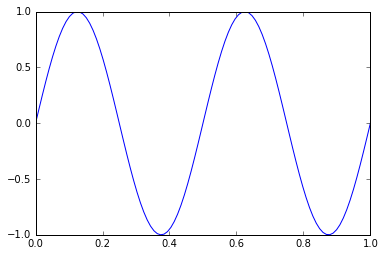

In [15]:
plot(x,sin(2*pi*x*f));

We can also create a function out of this line and provide frequency as an argument:

In [16]:
def pltsin(f):
    plot(x,sin(2*pi*x*f))

In order to plot with different frequencies we have to always change the value of input argument:

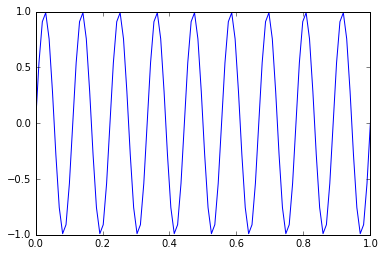

In [17]:
pltsin(9)

Bet there is a better way to do this - use `interact`. You give it the name of the function as a first argument, and parameter that you would like to vary (`f` in our case) with some limits (from 1 to 10) and step (0.1).

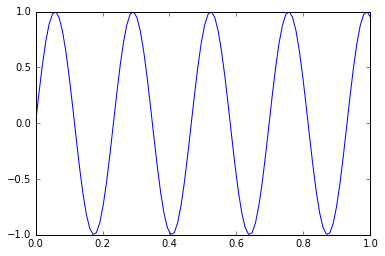

In [18]:
interact(pltsin, f=(1,10,0.1));

Now you can interactively change frequency and immediately see the result. This slider will work with both mouse and arrow keys.

Let’s add another parameter - amplitude (`a`):

In [19]:
def pltsin(f, a):
    plot(x,a*sin(2*pi*x*f))
    ylim(-10,10)

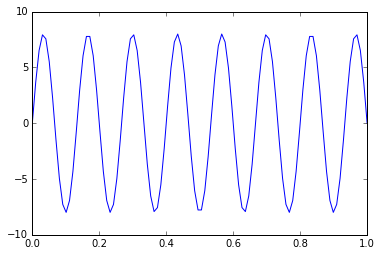

In [20]:
interact(pltsin, f=(1,10,0.1), a=(1,10,1));

Now we have to sliders, and we can vary two parameters independently.

Now for something completely different. We going to explore netCDF data with `interact`, but first we have to download them. Here is a little script, that will download daily air temperature, relative humidity, and wind components from NCEP reanalysis:

In [21]:
variabs = ['air', 'uwnd', 'vwnd', 'rhum']
for vvv in variabs:
    for i in range(2000,2010):
        !wget ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface/{vvv}.sig995.{i}.nc

--2015-05-19 09:32:53--  ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2000.nc
           => ‘air.sig995.2000.nc’
Resolving ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)... 140.172.38.117
Connecting to ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)|140.172.38.117|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Datasets/ncep.reanalysis.dailyavgs/surface ... done.
==> SIZE air.sig995.2000.nc ... 7470114
==> PASV ... done.    ==> RETR air.sig995.2000.nc ... done.
Length: 7470114 (7.1M) (unauthoritative)

100%[======================================>] 7,470,114    703KB/s   in 9.2s   

2015-05-19 09:33:05 (791 KB/s) - ‘air.sig995.2000.nc’ saved [7470114]

--2015-05-19 09:33:05--  ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2001.nc
           => ‘air.sig995.2001.nc’
Resolving ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)... 140.172.38.117
Connecting to ftp.cdc.noaa.gov (ftp.cd

First consider simplest one file case. We open the file:

In [22]:
f = Dataset('air.sig995.2000.nc')

Get our variable:

In [23]:
air = f.variables['air']

And display first time step:

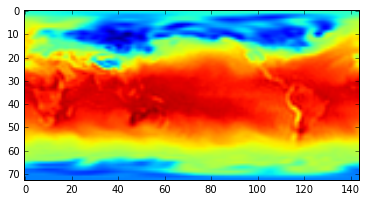

In [24]:
imshow(air[0,:,:])

Obvious thing to do is to browse through days. We make our plotting function:

In [25]:
def sh(time):
    imshow(air[time,:,:])

That will take day's number as an argument:

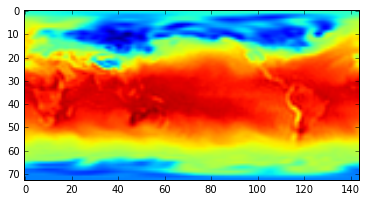

In [26]:
sh(0)

And make it interactive:

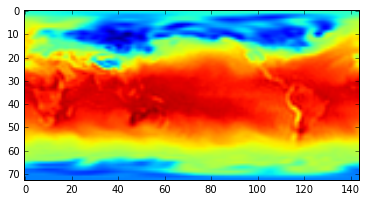

In [27]:
interact(sh, time=(0,355,1));

But what if we would like to switch between variables? We can do this by adding another argument (we just open different files):

In [28]:
def sh(var='air', time=0):
    f = Dataset(var+'.sig995.2000.nc')
    vv = f.variables[var]
    imshow(vv[time,:,:])

For our `interact` function we also have to have list of all possible variables:

In [29]:
variabs = ['air', 'uwnd', 'vwnd', 'rhum']

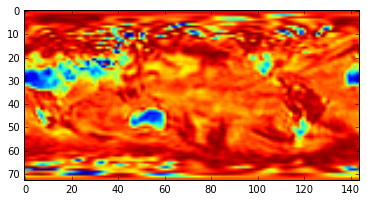

In [30]:
interact(sh, time=(0,355,1), var=variabs);

Since we give is a list, `interact` creates not a slider, but drop-down list.

Let's add years to the picture:

In [31]:
def sh(year='2000',var='air', time=0):
    f = Dataset(var+'.sig995.'+year+'.nc')
    vv = f.variables[var]
    imshow(vv[time,:,:])

I don't want to select years with slider, I want them to be also a drop down list, so I form the the list with years: 

In [32]:
years = [str(x) for x in range(2000,2010)]

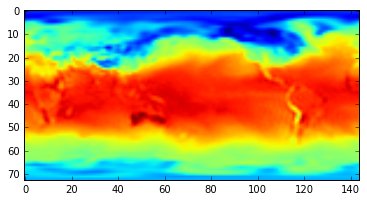

In [33]:
interact(sh, year=years, time=(0,355,1), var=variabs);

Two drop-down lists and a slider. Already looks pretty much like a serious GUI and all in just a few lines of code.

The problem with previous versions is that color scale is jumping together with data. This is not always nice, especially if we want to compare things. So let's add a check-box (boolean variable) that will switch from "jumping" to constant color scale, and upper and lower limits:

In [34]:
def sh(year='2000',var='air', FixedColor=False, vm=-3., vma=0., time=0):
    f = Dataset(var+'.sig995.'+year+'.nc')
    vv = f.variables[var]
    if FixedColor==False:
        imshow(vv[time,:,:])
        colorbar()
    else:
        imshow(vv[time,:,:], vmin=vm, vmax=vma)
        colorbar()

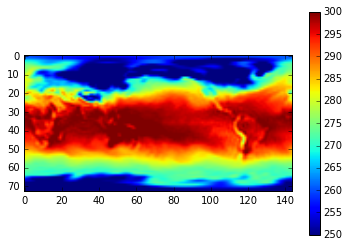

In [35]:
interact(sh, year=years, time=(0,355,1), var=variabs,\
         vm=FloatTextWidget(value=250), vma=FloatTextWidget(value=300));

Here in case of the limits it is not clear what widget `interact` should use, so you can provide the name of it directly. The list of widgets is quite long and can be obtained like this: 

In [36]:
from IPython.html import widgets
[widget for widget in dir(widgets) if widget.endswith('Widget')]

['AccordionWidget',
 'BoundedFloatTextWidget',
 'BoundedIntTextWidget',
 'ButtonWidget',
 'CheckboxWidget',
 'ContainerWidget',
 'DOMWidget',
 'DropdownWidget',
 'FloatProgressWidget',
 'FloatSliderWidget',
 'FloatTextWidget',
 'HTMLWidget',
 'ImageWidget',
 'IntProgressWidget',
 'IntSliderWidget',
 'IntTextWidget',
 'LatexWidget',
 'RadioButtonsWidget',
 'SelectWidget',
 'TabWidget',
 'TextWidget',
 'TextareaWidget',
 'ToggleButtonWidget',
 'ToggleButtonsWidget',
 'Widget']

Often you want to have not just simple *heat-map* representation of your data, but really the map. You can do this with help of Basemap. It will work surprisingly fast (at least in case of this small data).

In [37]:
from mpl_toolkits.basemap import Basemap

In [38]:
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')

In [39]:
lon = f.variables['lon'][:]
lat = f.variables['lat'][:]
lon, lat = np.meshgrid(lon, lat)
x, y = m(lon, lat)

In [43]:
def sh(year='2000',var='air', FixedColor=False, vm=-3., vma=0., inte=10, time=0):
    f = Dataset(var+'.sig995.'+year+'.nc')
    vv = f.variables[var]
    tt = f.variables['time']
    dd = num2date(tt[time], tt.units)
    if FixedColor==False:
        m.fillcontinents(color='gray',lake_color='gray')
        m.drawparallels(np.arange(-80.,81.,20.))
        m.drawmeridians(np.arange(-180.,181.,20.))
        m.drawmapboundary(fill_color='white')
        cs = m.contourf(x,y,vv[time,:,:]-273.15)
        #imshow(vv[time,:,:])
        colorbar()
        title(str(dd))
        
    else:
        m.fillcontinents(color='gray',lake_color='gray')
        m.drawparallels(np.arange(-80.,81.,20.))
        m.drawmeridians(np.arange(-180.,181.,20.))
        m.drawmapboundary(fill_color='white')
        cs = m.contourf(x,y,vv[time,:,:], levels = linspace(vm,vma,inte))
        #imshow(vv[time,:,:])
        colorbar()
        title(str(dd))

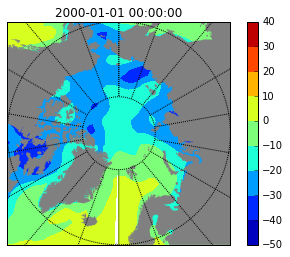

In [44]:
interact(sh, year=years, time=(0,355,1), var=variabs,\
         vm=FloatTextWidget(value=250), vma=FloatTextWidget(value=300), inte=FloatTextWidget(value=10));